In [1]:
import cv2
import numpy as np
import time
import scipy.ndimage.filters as fi
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as fn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
def save(model, i=None, name=None):
    i = i or 0
    name = name or type(model).__name__ + str(i)
    torch.save(model.state_dict(), 'dat/' + name + '.pth')

def load(model, i=None, name=None):
    i = i or 0
    name = name or type(model).__name__ + str(i)
    model.load_state_dict(torch.load('dat/' + name + '.pth'))

In [4]:
class FrameDataset(Dataset):
    def __init__(self, img_dir, n, transform=None, target_transform=None):
        self.img_dir = img_dir.rstrip('/').rstrip('\\')
        self.n = n
        with open(self.img_dir + '/control.dat', "r") as f:
            self.frame_map = np.array(f.read().split(' '), dtype='int32')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return min(self.n-2, len(self.frame_map))

    def __getitem__(self, idx):
        img_path = self.img_dir + '/frame%d.jpg'
        idx = self.frame_map[idx]
        im1 = cv2.imread(img_path % idx)
        label = cv2.imread(img_path % (idx+1))
        im2 = cv2.imread(img_path % (idx+2))
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
        if self.target_transform:
            label = self.target_transform(label)
        image = [im1,im2]
        return torch.Tensor(np.array(image)), torch.Tensor(np.array([label]))

In [9]:
#from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
class ConvNet(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        channels = input_shape[2]
        self.main = nn.Sequential(
            nn.Conv2d(channels, 8, (7,7), padding='same', bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 8, (7,7), padding='same', bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 8, (7,7), padding='same', bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 32, (3,3), padding='same', bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, channels//2, (3,3), padding='same'))
    def forward(self, x):
        return self.main(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        channels = input_shape[2]
        self.main = nn.Sequential(
            nn.Conv2d(channels, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [14]:
modelG = ConvNet((360,360,2)).to(device)
modelG.apply(weights_init)

modelD = Discriminator((360,360,3)).to(device)
modelD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [11]:
def squish(inputs, labels):
    return torch.cat((inputs, labels), dim = 1)

In [12]:
def puppy(im):
    return im[:,:,0]/128 - 1

training_data = FrameDataset('dat/part0/',2016, puppy, puppy)
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

In [15]:
criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = 0.0001, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = 0.0001, betas=(0.5, 0.999))

#training_lossD=[]
#training_lossG=[]

In [19]:
modelG.train()
modelD.train()

t = 0
for epoch in range(5):

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        size = len(inputs)


        outputs = modelG(inputs)

        real = squish(inputs, labels).to(device)
        fake = squish(inputs, outputs).to(device)

        # train Discriminant
        optimizerD.zero_grad()

        real_resD = modelD(real).view(-1)
        real_lossD = criterion(real_resD, torch.full_like(real_resD, 1))
        real_lossD.backward()
        optimizerD.step()

        fake_resD = modelD(fake.detach()).view(-1)
        fake_lossD = criterion(fake_resD, torch.full_like(fake_resD, 0))
        fake_lossD.backward()
        optimizerD.step()

        # train Generator
        optimizerG.zero_grad()

        resD = modelD(fake).view(-1)
        lossG = criterion(resD, torch.full_like(resD, 1))
        lossG.backward()
        optimizerG.step()

        # print statistics
        if i % 10 == 0:
            print('[%d, %5d] real_lossD: %.4f (%.4f), fake_lossD: %.4f (%.4f), lossG: %.4f (%.4f)' % (
              epoch + 1, i + 1, real_lossD.item(), real_resD.mean().item(), fake_lossD.item(),
              fake_resD.mean().item(), lossG.item(), resD.mean().item()))
        training_lossD.append((real_lossD.item()+fake_lossD.item())/2)
        training_lossG.append(lossG.item())
        
    if time.time() > t + 1000:
        save(modelG)
        save(modelD)
        t = time.time()
        print('Model checkpoint')

save(modelG)
save(modelD)
print('Finished Training')

[1,     1] real_lossD: 0.1761 (0.8634), fake_lossD: 0.2601 (0.2012), lossG: 2.7128 (0.1082)
[1,    11] real_lossD: 0.0419 (0.9599), fake_lossD: 0.0761 (0.0722), lossG: 2.8955 (0.0641)
[1,    21] real_lossD: 0.0231 (0.9773), fake_lossD: 0.0225 (0.0221), lossG: 4.0131 (0.0216)
[1,    31] real_lossD: 0.0123 (0.9878), fake_lossD: 0.0299 (0.0292), lossG: 3.8903 (0.0249)
[1,    41] real_lossD: 0.0094 (0.9907), fake_lossD: 0.0094 (0.0093), lossG: 4.8968 (0.0090)
[1,    51] real_lossD: 0.0097 (0.9904), fake_lossD: 0.0346 (0.0336), lossG: 3.8630 (0.0250)
[1,    61] real_lossD: 0.0091 (0.9910), fake_lossD: 0.0259 (0.0252), lossG: 4.3635 (0.0171)
Model checkpoint
[2,     1] real_lossD: 0.0100 (0.9902), fake_lossD: 0.0270 (0.0262), lossG: 4.4708 (0.0156)
[2,    11] real_lossD: 0.0249 (0.9757), fake_lossD: 0.4987 (0.2873), lossG: 4.3357 (0.0527)
[2,    21] real_lossD: 0.0090 (0.9910), fake_lossD: 0.0323 (0.0303), lossG: 4.3469 (0.0204)
[2,    31] real_lossD: 0.0070 (0.9931), fake_lossD: 0.0877 (0.0

In [20]:
plt.plot(training_lossD, label="discriminator")
plt.plot(training_lossG, label='generator')
plt.xticks(np.arange(0,631,63),np.arange(11))
plt.xlabel('epochs')
plt.legend()
plt.show()

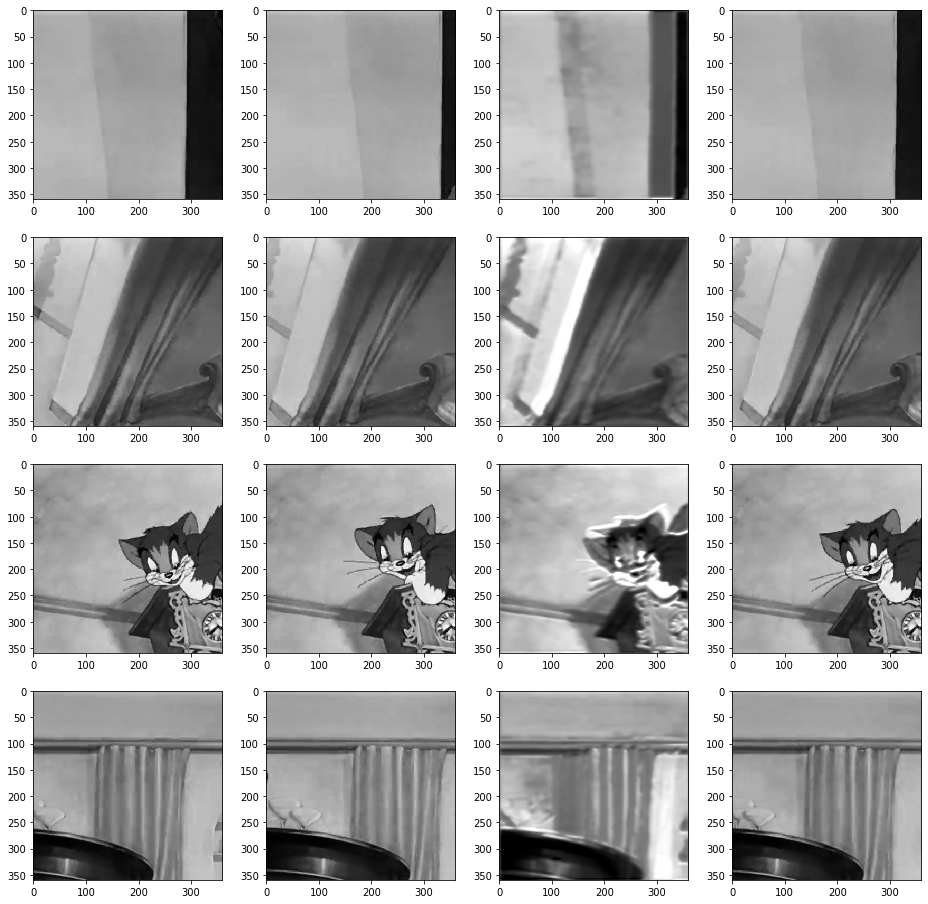

In [22]:
n=3
ins = inputs.cpu().detach()
outs = outputs.cpu().detach()
mids = labels.cpu().detach()
figure, axes = plt.subplots(4,4, figsize=(16,16))
for i in range(4):
    axes[i][0].imshow(ins[n*i][0],cmap='gray', vmin=-1, vmax=1)
    axes[i][1].imshow(ins[n*i][1],cmap='gray', vmin=-1, vmax=1)
    axes[i][2].imshow(outs[n*i][0],cmap='gray', vmin=-1, vmax=1)
    axes[i][3].imshow(mids[n*i][0],cmap='gray', vmin=-1, vmax=1)

plt.show()